In [1]:
import sys
import importlib

sys.path.insert(0, '/Users/awgol/code/syne-tune/')

import syne_tune
importlib.reload(syne_tune)

import syne_tune.experiments
importlib.reload(syne_tune.experiments)

from syne_tune.util import experiment_path, s3_experiment_path
importlib.reload(syne_tune.util)

import adam_scripts.utils
importlib.reload(adam_scripts.utils)

import pygmo

import numpy as np
import pandas as pd
import tqdm
import boto3

from syne_tune.backend.sagemaker_backend.instance_info import InstanceInfos
instance_info = InstanceInfos()

import matplotlib.pyplot as plt

import seaborn as sns

# from syne_tune.optimizer.schedulers.transfer_learning.quantile_based.normalization_transforms import (
#     GaussianTransform)

from sklearn.preprocessing import QuantileTransformer

In [2]:
boto3_client_sagemaker = boto3.client('sagemaker')
boto3_resource_cloudwatch = boto3.resource('cloudwatch')

In [3]:
df = syne_tune.experiments.load_experiment(
    'speed-bs-it-nw-new-2022-02-21-18-05-01-921', 
    force_download=False
).results

In [4]:
# Syne Tune's st_worker_time and st_tuner_cost do not account for either:
# a) the EC2 instance startup overhead time (customers don't pay for this)
# b) the time at the beginning of the running of the script (starting the script, setting up the dataloader etc)
# We assume an idealized scenario where we have each instance type already running and with dataloader prepared,
# such that they're all ready to start our jobs. Hence we can omit both effects a) and b).
# However, we still assume the attempts that fail due to OOM, incur the cost equivalent to SCRIPT_SETUP_OVERHEAD_TIME.
INSTANCE_STARTUP_OVERHEAD_TIME = 0  # in seconds
# This was estimated as the median of "BillableTimeInSeconds-st_worker_time" for runs of a given training script
# (gluonts-on-electricity or hugging-distil-bert-finetunes-on-imdb).
# For gluonts on 'deepar-speed-bs-32-2022-04-21-14-48-44-131': SCRIPT_SETUP_OVERHEAD_TIME = 65
# For distill-bert-on-imdb on 'loss-lr-wd-bs-2-2022-02-07-23-13-30-781': SCRIPT_SETUP_OVERHEAD_TIME = 410
SCRIPT_SETUP_OVERHEAD_TIME = 0  # in seconds

# The speed benchmarking experiments were run for max_run=5min timeout setting of the HuggingFace estimator.
# If we are more efficient about software engineering of the solution we could run only a few batches
# and do it cheaper.
ST_WORKER_TIME_DISCOUNT = 0.1

In [5]:
# Drop duplicates resulting from what I understand is the following issue
# https://github.com/awslabs/syne-tune/issues/214
temp = df.groupby(['trial_id', 'step']).loss.count().reset_index()
trial_ids_to_be_deleted = temp[temp.loss>1].trial_id.unique() 
trial_ids_to_be_deleted

array([2])

In [6]:
df.drop(df.index[df['trial_id'].isin(trial_ids_to_be_deleted)], inplace=True)

In [7]:
# speed-bs-it-nw-new-2022-02-21-18-05-01-921-82

In [8]:
# Compute time per samples
dfg = df.groupby(['trial_id'])

number_of_samples_processed = (
  dfg.step.max() * 
  dfg.config_per_device_train_batch_size.max() * 
  dfg.config_st_instance_type.max().map(lambda x: instance_info(x).num_gpu))

samples_processed_per_second = number_of_samples_processed / dfg.st_worker_time.max()
time_per_sample = dfg.st_worker_time.max() / number_of_samples_processed
cost_per_sample = time_per_sample * dfg.config_st_instance_type.max().map(lambda x: instance_info(x).cost_per_hour)

In [9]:
# The records that have only 100 steps record, which means that their time_per_sample cannot be estimated 
# by taking the difference between the first and last record.
# We do it this way such that the results are free of the bias reflected in st_tuner_time due to the 
# script_startup_overhead.

# These are trial_ids corresponding to the trials with only 100 steps records
dfg.step.max().index[np.argwhere((dfg.step.max()==100).to_numpy()).reshape(-1)]

Int64Index([82, 295, 377], dtype='int64', name='trial_id')

In [10]:
b = pd.concat([
    samples_processed_per_second, 
    time_per_sample,
    cost_per_sample,
    dfg.config_seed.max(),
    dfg.st_worker_cost.max(), 
    dfg.config_st_instance_type.max(), 
    dfg.config_per_device_train_batch_size.max(),
    dfg.config_dataloader_num_workers.max(),
], axis=1)
columns = ['samples_processed_per_second', 'time_per_sample', 'cost_per_sample']
b.columns = columns + list(b.columns)[len(columns):]

b = (
    b.groupby([
        'config_st_instance_type', 
        'config_per_device_train_batch_size', 
        'config_dataloader_num_workers'
    ]).agg({
        'samples_processed_per_second': 'mean',
        'time_per_sample': 'mean',
        'cost_per_sample': 'mean',
        'st_worker_cost': 'mean',
}).reset_index())

Add failed runs

In [11]:
# per_device_train_batch_size_list = [4, 8, 16, 24, 32, 40, 48]
per_device_train_batch_size_list = [8, 16, 24, 32, 40, 48]
dataloader_num_workers_list = [0, 1]
instance_types = [
        'ml.p3.2xlarge',
        'ml.p2.xlarge',
        'ml.p2.8xlarge',
        'ml.g4dn.xlarge',
        'ml.g4dn.2xlarge',
        'ml.g4dn.4xlarge',
        'ml.g4dn.8xlarge',
        'ml.g4dn.12xlarge',
        'ml.g5.xlarge',
        'ml.g5.2xlarge',
        'ml.g5.4xlarge',
        'ml.g5.8xlarge',
        'ml.g5.12xlarge',
        'ml.g5.24xlarge',
    ]

In [12]:
names = [
    "config_st_instance_type", 
    "config_per_device_train_batch_size", 
    "config_dataloader_num_workers"
]

mind = pd.MultiIndex.from_product(
    [instance_types, per_device_train_batch_size_list, dataloader_num_workers_list], 
    names=names)
c = b.set_index(names).reindex(mind)

In [13]:
len(c)

168

In [14]:
len(instance_types)

14

In [15]:
2*14*6

168

In [16]:
for idx in c.st_worker_cost.isna().loc[lambda x: x==True].index:
    c.loc[idx].samples_processed_per_second = 0.0
    c.loc[idx].time_per_sample = 1.
    c.loc[idx].cost_per_sample = 1.
    c.loc[idx].config_seed = 1
    c.loc[idx].st_worker_cost = (instance_info(idx[0]).cost_per_hour /
                                 60. / 60. * SCRIPT_SETUP_OVERHEAD_TIME)

In [17]:
c = c.reset_index()

### Normalization

In [18]:
temp = c
y_all_points = np.stack([
    temp.time_per_sample,
    temp.cost_per_sample
], axis=-1)

In [19]:
y_all_points.shape

(168, 2)

In [20]:
normalizer = QuantileTransformer(output_distribution='uniform')
normalizer.fit(y_all_points)

/Users/awgol/libs/miniconda3/envs/aws1/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (168). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)


QuantileTransformer()

In [21]:
ref_point = (1.+1e-15, 1.+1e-15)

In [22]:
def compute_hv(inputs_unnorm):
    inputs_unnorm_vec = np.stack([inputs_unnorm.time_per_sample, inputs_unnorm.cost_per_sample], axis=-1)
    inputs_norm_vec = normalizer.transform(inputs_unnorm_vec)
    hv = pygmo.hypervolume(inputs_norm_vec.tolist()).compute(ref_point)
    return hv

In [23]:
c[c.time_per_sample.isna()]

,config_st_instance_type,config_per_device_train_batch_size,config_dataloader_num_workers,samples_processed_per_second,time_per_sample,cost_per_sample,st_worker_cost


In [24]:
true_hv = compute_hv(c)
true_hv

0.9621356090214795

In [25]:
# https://stackoverflow.com/questions/32791911/fast-calculation-of-pareto-front-in-python

# Faster than is_pareto_efficient_simple, but less readable.
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

In [26]:
inputs_unnorm = c
inputs_unnorm_vec = np.stack([inputs_unnorm.time_per_sample, inputs_unnorm.cost_per_sample], axis=-1)
inputs_norm_vec = normalizer.transform(inputs_unnorm_vec)
pygmo.hypervolume(inputs_norm_vec.tolist()).get_points()

inputs_unnorm[is_pareto_efficient(inputs_norm_vec)]

,config_st_instance_type,config_per_device_train_batch_size,config_dataloader_num_workers,samples_processed_per_second,time_per_sample,cost_per_sample,st_worker_cost
105,ml.g5.xlarge,40,1,74.675062,0.013391,0.013472,0.134718
155,ml.g5.12xlarge,48,1,236.335510,0.004231,0.024000,0.383999


### Reused code

In [27]:
data = dict()
costs = dict()

In [28]:
def compute_hvs_and_cost(temp, scenario_label, K):
    hvs_total = []
    costs_total = []
    for n in tqdm.trange(N):
        idxs = np.random.choice(K, size=K, replace=False)
        hvs_temp = []
        costs_temp = []
        for k in range(1, K + 1):
            temp2 = temp.iloc[idxs[:k]]
            hv = compute_hv(temp2)
            hvs_temp.append(hv)
            costs_temp.append(
                temp.st_worker_cost.iloc[idxs[k-1]] * ST_WORKER_TIME_DISCOUNT +
                SCRIPT_SETUP_OVERHEAD_TIME / 60. / 60. *
                instance_info(temp.config_st_instance_type.iloc[idxs[k-1]]).cost_per_hour
            )
        hvs_total.append(hvs_temp)
        costs_total.append(costs_temp)

    data[scenario_label] = np.array(hvs_total)
    costs[scenario_label] = np.array(costs_total).cumsum(axis=1)

## random

In [29]:
N = 100

In [30]:
temp = c
scenario_label = 'random'
K = len(temp)

compute_hvs_and_cost(temp, scenario_label, K)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.67it/s]


## only cheapest instance per GPU-type-and-number

In [31]:
instance_types = [
        'ml.p3.2xlarge',
        'ml.p2.xlarge',
        'ml.p2.8xlarge',
        'ml.g4dn.xlarge',
        # 'ml.g4dn.2xlarge',
        # 'ml.g4dn.4xlarge',
        # 'ml.g4dn.8xlarge',
        'ml.g4dn.12xlarge',
        'ml.g5.xlarge',
        # 'ml.g5.2xlarge',
        # 'ml.g5.4xlarge',
        # 'ml.g5.8xlarge',
        'ml.g5.12xlarge',
#         'ml.g5.24xlarge',
    ]

temp = c.query('config_st_instance_type in @instance_types')
scenario_label = 'cheapest_instances'

K = len(temp)


compute_hvs_and_cost(temp, scenario_label, K)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.75it/s]


## deterministically determining largest possible batch_size using only 1 instance_type

In [32]:
instance_types = [
        'ml.p3.2xlarge',
        'ml.p2.xlarge',
        'ml.p2.8xlarge',
        'ml.g4dn.xlarge',
        'ml.g4dn.2xlarge',
        'ml.g4dn.4xlarge',
        'ml.g4dn.8xlarge',
        'ml.g4dn.12xlarge',
        'ml.g5.xlarge',
        'ml.g5.2xlarge',
        'ml.g5.4xlarge',
        'ml.g5.8xlarge',
        'ml.g5.12xlarge',
        'ml.g5.24xlarge',
    ]


temp = c.query('config_st_instance_type in @instance_types')
temp = (
    temp
    .groupby('config_st_instance_type')
    .apply(lambda group: group.loc[group['config_per_device_train_batch_size'] == group['config_per_device_train_batch_size'].max()])
    .reset_index(drop=True)
)
scenario_label = 'determine_batch_size_one_instance_type'

K = len(temp)

compute_hvs_and_cost(temp, scenario_label, K)

# add the cost of running two runs for each instance_type
instance_type = 'ml.g5.xlarge'
costs[scenario_label] += (
    2 * ST_WORKER_TIME_DISCOUNT * 
    temp.groupby('config_st_instance_type').st_worker_cost.min()[instance_type])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.90it/s]


In [33]:
instance_types = [
        'ml.p3.2xlarge',
        'ml.p2.xlarge',
        'ml.p2.8xlarge',
        'ml.g4dn.xlarge',
        # 'ml.g4dn.2xlarge',
        # 'ml.g4dn.4xlarge',
        # 'ml.g4dn.8xlarge',
        'ml.g4dn.12xlarge',
        'ml.g5.xlarge',
        # 'ml.g5.2xlarge',
        # 'ml.g5.4xlarge',
        # 'ml.g5.8xlarge',
        'ml.g5.12xlarge',
        # 'ml.g5.24xlarge',
    ]


temp = c.query('config_st_instance_type in @instance_types')
temp = (
    temp
    .groupby('config_st_instance_type')
    .apply(lambda group: group.loc[group['config_per_device_train_batch_size'] == group['config_per_device_train_batch_size'].max()])
    .reset_index(drop=True)
)
scenario_label = 'determine_batch_size_one_instance_type_cheapest_instances'

K = len(temp)


compute_hvs_and_cost(temp, scenario_label, K)

# add the cost of running two runs for each instance_type
instance_type = 'ml.g5.xlarge'
costs[scenario_label] += 2 * temp.groupby('config_st_instance_type').st_worker_cost.min()[instance_type]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 79.20it/s]


## Syne Tune RandomSearch

In [34]:
def populate_with_syne_tune_results(scenario_label, runs):
    temp_data = []
    temp_cost = []
    for run in runs:
        dfff = syne_tune.experiments.load_experiment(run).results

        inputs_unnorm_vec = np.stack([dfff['training-runtime-per-sample'], dfff['training-cost-per-sample']], axis=-1)
        inputs_norm_vec = normalizer.transform(inputs_unnorm_vec)
        temp_data.append([
            pygmo.hypervolume(inputs_norm_vec[:i+1].tolist()).compute(ref_point) 
            for i in range(len(dfff))
        ])

        temp_cost.append(np.cumsum(dfff.st_worker_cost))

    min_index = min(len(v) for v in temp_data)
    data[scenario_label] = np.zeros((len(temp_data), min_index))
    costs[scenario_label] = np.zeros((len(temp_data), min_index))
    for i in range(len(temp_data)):
        data[scenario_label][i, :] = temp_data[i][:min_index]
        costs[scenario_label][i, :] = temp_cost[i][:min_index]

#     print(data[scenario_label].shape)

In [35]:
# rs_runs = [
#     'simulated-tabular-backend-2022-04-01-13-42-35-763', 'simulated-tabular-backend-2022-04-01-13-42-37-815', 'simulated-tabular-backend-2022-04-01-13-42-39-863', 'simulated-tabular-backend-2022-04-01-13-42-41-938', 'simulated-tabular-backend-2022-04-01-13-42-43-953', 'simulated-tabular-backend-2022-04-01-13-42-45-992', 'simulated-tabular-backend-2022-04-01-13-42-48-070', 'simulated-tabular-backend-2022-04-01-13-42-50-316', 'simulated-tabular-backend-2022-04-01-13-42-52-537', 'simulated-tabular-backend-2022-04-01-13-42-55-437', 'simulated-tabular-backend-2022-04-01-13-42-58-179', 'simulated-tabular-backend-2022-04-01-13-43-01-191', 'simulated-tabular-backend-2022-04-01-13-43-03-678', 'simulated-tabular-backend-2022-04-01-13-43-05-897', 'simulated-tabular-backend-2022-04-01-13-43-08-069', 'simulated-tabular-backend-2022-04-01-13-43-10-372', 'simulated-tabular-backend-2022-04-01-13-43-12-560', 'simulated-tabular-backend-2022-04-01-13-43-15-010', 'simulated-tabular-backend-2022-04-01-13-43-17-770', 'simulated-tabular-backend-2022-04-01-13-43-20-113', 'simulated-tabular-backend-2022-04-01-13-43-22-246', 'simulated-tabular-backend-2022-04-01-13-43-24-663', 'simulated-tabular-backend-2022-04-01-13-43-26-981', 'simulated-tabular-backend-2022-04-01-13-43-29-563', 'simulated-tabular-backend-2022-04-01-13-43-31-787', 'simulated-tabular-backend-2022-04-01-13-43-34-793', 'simulated-tabular-backend-2022-04-01-13-43-37-010', 'simulated-tabular-backend-2022-04-01-13-43-39-169', 'simulated-tabular-backend-2022-04-01-13-43-41-701', 'simulated-tabular-backend-2022-04-01-13-43-43-842', 'simulated-tabular-backend-2022-04-01-13-43-46-041', 'simulated-tabular-backend-2022-04-01-13-43-48-163', 'simulated-tabular-backend-2022-04-01-13-43-50-307', 'simulated-tabular-backend-2022-04-01-13-43-52-436', 'simulated-tabular-backend-2022-04-01-13-43-54-685', 'simulated-tabular-backend-2022-04-01-13-43-56-829', 'simulated-tabular-backend-2022-04-01-13-43-59-276', 'simulated-tabular-backend-2022-04-01-13-44-02-065', 'simulated-tabular-backend-2022-04-01-13-44-04-437', 'simulated-tabular-backend-2022-04-01-13-44-06-527', 'simulated-tabular-backend-2022-04-01-13-44-08-667', 'simulated-tabular-backend-2022-04-01-13-44-11-330', 'simulated-tabular-backend-2022-04-01-13-44-13-588', 'simulated-tabular-backend-2022-04-01-13-44-15-738', 'simulated-tabular-backend-2022-04-01-13-44-18-026', 'simulated-tabular-backend-2022-04-01-13-44-20-390', 'simulated-tabular-backend-2022-04-01-13-44-22-647', 'simulated-tabular-backend-2022-04-01-13-44-24-886', 'simulated-tabular-backend-2022-04-01-13-44-26-983', 'simulated-tabular-backend-2022-04-01-13-44-29-292', 'simulated-tabular-backend-2022-04-01-13-44-31-572', 'simulated-tabular-backend-2022-04-01-13-44-33-879', 'simulated-tabular-backend-2022-04-01-13-44-36-124', 'simulated-tabular-backend-2022-04-01-13-44-38-556', 'simulated-tabular-backend-2022-04-01-13-44-41-320', 'simulated-tabular-backend-2022-04-01-13-44-43-844', 'simulated-tabular-backend-2022-04-01-13-44-46-413', 'simulated-tabular-backend-2022-04-01-13-44-48-760', 'simulated-tabular-backend-2022-04-01-13-44-51-144', 'simulated-tabular-backend-2022-04-01-13-44-53-455', 'simulated-tabular-backend-2022-04-01-13-44-55-996', 'simulated-tabular-backend-2022-04-01-13-44-58-412', 'simulated-tabular-backend-2022-04-01-13-45-00-731', 'simulated-tabular-backend-2022-04-01-13-45-03-031', 'simulated-tabular-backend-2022-04-01-13-45-05-363', 'simulated-tabular-backend-2022-04-01-13-45-07-762', 'simulated-tabular-backend-2022-04-01-13-45-10-286', 'simulated-tabular-backend-2022-04-01-13-45-12-605', 'simulated-tabular-backend-2022-04-01-13-45-15-018', 'simulated-tabular-backend-2022-04-01-13-45-17-383', 'simulated-tabular-backend-2022-04-01-13-45-19-874', 'simulated-tabular-backend-2022-04-01-13-45-22-214', 'simulated-tabular-backend-2022-04-01-13-45-24-470', 'simulated-tabular-backend-2022-04-01-13-45-26-971', 'simulated-tabular-backend-2022-04-01-13-45-29-683', 'simulated-tabular-backend-2022-04-01-13-45-31-973', 'simulated-tabular-backend-2022-04-01-13-45-34-147', 'simulated-tabular-backend-2022-04-01-13-45-36-261', 'simulated-tabular-backend-2022-04-01-13-45-38-432', 'simulated-tabular-backend-2022-04-01-13-45-40-722', 'simulated-tabular-backend-2022-04-01-13-45-42-978', 'simulated-tabular-backend-2022-04-01-13-45-45-239', 'simulated-tabular-backend-2022-04-01-13-45-47-196', 'simulated-tabular-backend-2022-04-01-13-45-49-074', 'simulated-tabular-backend-2022-04-01-13-45-50-984', 'simulated-tabular-backend-2022-04-01-13-45-52-888', 'simulated-tabular-backend-2022-04-01-13-45-54-804', 'simulated-tabular-backend-2022-04-01-13-45-56-763', 'simulated-tabular-backend-2022-04-01-13-45-58-668', 'simulated-tabular-backend-2022-04-01-13-46-00-548', 'simulated-tabular-backend-2022-04-01-13-46-02-403', 'simulated-tabular-backend-2022-04-01-13-46-04-348', 'simulated-tabular-backend-2022-04-01-13-46-06-522', 'simulated-tabular-backend-2022-04-01-13-46-08-744', 'simulated-tabular-backend-2022-04-01-13-46-10-874', 'simulated-tabular-backend-2022-04-01-13-46-12-778', 'simulated-tabular-backend-2022-04-01-13-46-14-704', 'simulated-tabular-backend-2022-04-01-13-46-16-578', 'simulated-tabular-backend-2022-04-01-13-46-18-385', 'simulated-tabular-backend-2022-04-01-13-46-20-242']

In [36]:
# scenario_label = 'rs_st'
# runs = rs_runs

# populate_with_syne_tune_results(scenario_label, runs)

## Rich-feature MOBO

In [37]:
# rf_mobo_runs = [
#     'simulated-tabular-backend-2022-04-07-14-22-51-061', 'simulated-tabular-backend-2022-04-07-14-23-52-407', 'simulated-tabular-backend-2022-04-07-14-24-20-376', 'simulated-tabular-backend-2022-04-07-14-24-48-987', 'simulated-tabular-backend-2022-04-07-14-25-15-335', 'simulated-tabular-backend-2022-04-07-14-25-38-987', 'simulated-tabular-backend-2022-04-07-14-26-14-501', 'simulated-tabular-backend-2022-04-07-14-26-30-440', 'simulated-tabular-backend-2022-04-07-14-27-03-554', 'simulated-tabular-backend-2022-04-07-14-27-27-091']

# rf_mobo_runs = [
#     'simulated-tabular-backend-2022-04-07-14-40-59-865', 'simulated-tabular-backend-2022-04-07-14-42-07-202', 'simulated-tabular-backend-2022-04-07-14-43-25-586', 'simulated-tabular-backend-2022-04-07-14-44-34-443', 'simulated-tabular-backend-2022-04-07-14-45-42-625', 'simulated-tabular-backend-2022-04-07-14-47-27-087', 'simulated-tabular-backend-2022-04-07-14-48-25-994', 'simulated-tabular-backend-2022-04-07-14-49-51-141', 'simulated-tabular-backend-2022-04-07-14-51-17-875', 'simulated-tabular-backend-2022-04-07-14-52-25-313']

# # max_cost=70., self.instance_type_features = ['GPUFP32TFLOPS', 'num_gpu', 'num_cpu', 'cost_per_hour']
# rf_mobo_runs = ['simulated-tabular-backend-2022-04-07-14-55-54-573', 'simulated-tabular-backend-2022-04-07-15-09-00-151']

# # max_cost=70., self.instance_type_features = ['GPUFP32TFLOPS', 'num_gpu', 'cost_per_hour']
# rf_mobo_runs = [
#     'simulated-tabular-backend-2022-04-07-15-20-15-689', 'simulated-tabular-backend-2022-04-07-15-22-17-915', 'simulated-tabular-backend-2022-04-07-15-24-10-379', 'simulated-tabular-backend-2022-04-07-15-26-05-736', 'simulated-tabular-backend-2022-04-07-15-28-07-394', 'simulated-tabular-backend-2022-04-07-15-30-04-821', 'simulated-tabular-backend-2022-04-07-15-31-53-983', 'simulated-tabular-backend-2022-04-07-15-33-48-174', 'simulated-tabular-backend-2022-04-07-15-35-31-210', 'simulated-tabular-backend-2022-04-07-15-37-17-189']

# # max_cost=20., self.instance_type_features = ['GPUFP32TFLOPS', 'num_gpu']

# # max_cost=20., self.instance_type_features = ['config_st_instance_type', 'num_gpu']
# rf_mobo_runs = ['simulated-tabular-backend-2022-04-08-14-30-00-850', 'simulated-tabular-backend-2022-04-08-14-30-27-821', 'simulated-tabular-backend-2022-04-08-14-30-48-042', 'simulated-tabular-backend-2022-04-08-14-31-30-577', 'simulated-tabular-backend-2022-04-08-14-32-06-036', 'simulated-tabular-backend-2022-04-08-14-32-33-762', 'simulated-tabular-backend-2022-04-08-14-32-48-042', 'simulated-tabular-backend-2022-04-08-14-33-08-101', 'simulated-tabular-backend-2022-04-08-14-33-20-845', 'simulated-tabular-backend-2022-04-08-14-33-44-442']

# # BASELINE
# # max_cost=20., self.instance_type_features = ['config_st_instance_type']
# rf_mobo_runs = ['simulated-tabular-backend-2022-04-08-14-40-52-917', 'simulated-tabular-backend-2022-04-08-14-41-10-941', 'simulated-tabular-backend-2022-04-08-14-41-50-172', 'simulated-tabular-backend-2022-04-08-14-42-06-368', 'simulated-tabular-backend-2022-04-08-14-42-30-473', 'simulated-tabular-backend-2022-04-08-14-42-53-084', 'simulated-tabular-backend-2022-04-08-14-43-12-323', 'simulated-tabular-backend-2022-04-08-14-43-34-447', 'simulated-tabular-backend-2022-04-08-14-43-52-548', 'simulated-tabular-backend-2022-04-08-14-44-16-604']

# # BASELINE AFTER GIT STASH
# rf_mobo_runs = ['simulated-tabular-backend-2022-04-08-15-25-00-304', 'simulated-tabular-backend-2022-04-08-15-25-21-356', 'simulated-tabular-backend-2022-04-08-15-25-55-514', 'simulated-tabular-backend-2022-04-08-15-26-12-394', 'simulated-tabular-backend-2022-04-08-15-26-29-980', 'simulated-tabular-backend-2022-04-08-15-26-53-001', 'simulated-tabular-backend-2022-04-08-15-27-05-618', 'simulated-tabular-backend-2022-04-08-15-27-25-286', 'simulated-tabular-backend-2022-04-08-15-27-43-510', 'simulated-tabular-backend-2022-04-08-15-28-26-086']

# # Unstashed, fixed a categorical embedding bug - now reproduces the results
# rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-08-52-44-256', 'simulated-tabular-backend-2022-04-11-08-53-30-477', 'simulated-tabular-backend-2022-04-11-08-54-29-240', 'simulated-tabular-backend-2022-04-11-08-54-52-139', 'simulated-tabular-backend-2022-04-11-08-55-21-475', 'simulated-tabular-backend-2022-04-11-08-55-42-895', 'simulated-tabular-backend-2022-04-11-08-56-15-720', 'simulated-tabular-backend-2022-04-11-08-56-45-222', 'simulated-tabular-backend-2022-04-11-08-57-23-555', 'simulated-tabular-backend-2022-04-11-08-57-52-127']

# # max_cost=20., self.instance_type_features = ['GPUFP32TFLOPS'] - still worse than random search
# rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-09-06-59-209', 'simulated-tabular-backend-2022-04-11-09-07-43-183', 'simulated-tabular-backend-2022-04-11-09-08-17-710', 'simulated-tabular-backend-2022-04-11-09-08-50-725']

# # max_cost=90., self.instance_type_features = ['GPUFP32TFLOPS'] - to test if it will go to zero
# rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-09-14-57-548', 'simulated-tabular-backend-2022-04-11-09-19-47-646']
# rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-09-50-31-343',]

# # max_cost=25., self.instance_type_features = ['cost_per_hour']
# rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-10-05-13-309', 'simulated-tabular-backend-2022-04-11-10-05-43-640']

# # BASELINE after refactoring
# rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-15-45-15-474', 'simulated-tabular-backend-2022-04-11-15-46-18-789', 'simulated-tabular-backend-2022-04-11-15-47-01-860', 'simulated-tabular-backend-2022-04-11-15-47-50-496', 'simulated-tabular-backend-2022-04-11-15-48-33-679', 'simulated-tabular-backend-2022-04-11-15-49-24-111', 'simulated-tabular-backend-2022-04-11-15-50-13-528', 'simulated-tabular-backend-2022-04-11-15-50-51-074', 'simulated-tabular-backend-2022-04-11-15-51-32-226', 'simulated-tabular-backend-2022-04-11-15-52-17-277']

# # after refactoring, max_cost=25., self.instance_type_features = ['cost_per_hour']
# rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-15-55-27-006', 'simulated-tabular-backend-2022-04-11-15-55-52-330', 'simulated-tabular-backend-2022-04-11-15-56-13-444', 'simulated-tabular-backend-2022-04-11-15-56-44-575', 'simulated-tabular-backend-2022-04-11-15-57-10-029', 'simulated-tabular-backend-2022-04-11-15-57-52-324', 'simulated-tabular-backend-2022-04-11-15-58-30-617', 'simulated-tabular-backend-2022-04-11-15-58-51-525', 'simulated-tabular-backend-2022-04-11-15-59-14-640', 'simulated-tabular-backend-2022-04-11-15-59-46-539']

# # after refactoring, max_cost=25., self.instance_type_features = ['GPUFP32TFLOPS']
# # actually improves things
# rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-16-40-34-902', 'simulated-tabular-backend-2022-04-11-16-41-32-274', 'simulated-tabular-backend-2022-04-11-16-42-22-119', 'simulated-tabular-backend-2022-04-11-16-43-23-825', 'simulated-tabular-backend-2022-04-11-16-44-17-644', 'simulated-tabular-backend-2022-04-11-16-44-52-512', 'simulated-tabular-backend-2022-04-11-16-46-08-876', 'simulated-tabular-backend-2022-04-11-16-47-16-703', 'simulated-tabular-backend-2022-04-11-16-48-08-034', 'simulated-tabular-backend-2022-04-11-16-49-17-501']

# # after refactoring, max_cost=25., self.instance_type_features = ['GPUFP32TFLOPS*num_gpu']
# # not as good as the previous one
# # rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-17-00-47-694', 'simulated-tabular-backend-2022-04-11-17-01-33-573', 'simulated-tabular-backend-2022-04-11-17-02-08-197', 'simulated-tabular-backend-2022-04-11-17-02-40-412', 'simulated-tabular-backend-2022-04-11-17-03-07-167', 'simulated-tabular-backend-2022-04-11-17-03-33-492', 'simulated-tabular-backend-2022-04-11-17-04-06-442', 'simulated-tabular-backend-2022-04-11-17-04-27-605', 'simulated-tabular-backend-2022-04-11-17-04-47-220', 'simulated-tabular-backend-2022-04-11-17-05-25-529']

# # after refactoring, max_cost=25., self.instance_type_features = ['GPUFP32TFLOPS*num_gpu', 'cost_per_hour']
# # exactly the same as just categorical
# # rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-17-06-28-297', 'simulated-tabular-backend-2022-04-11-17-07-32-765', 'simulated-tabular-backend-2022-04-11-17-08-06-675', 'simulated-tabular-backend-2022-04-11-17-08-41-604', 'simulated-tabular-backend-2022-04-11-17-09-08-951', 'simulated-tabular-backend-2022-04-11-17-09-44-527', 'simulated-tabular-backend-2022-04-11-17-10-10-429', 'simulated-tabular-backend-2022-04-11-17-10-51-152', 'simulated-tabular-backend-2022-04-11-17-11-13-969', 'simulated-tabular-backend-2022-04-11-17-11-34-681']

# # 100 trials, max_cost=50., self.instance_type_features = ['GPUFP32TFLOPS']
# rf_mobo_runs = ['simulated-tabular-backend-2022-04-11-17-33-57-906', 'simulated-tabular-backend-2022-04-11-17-35-39-266', 'simulated-tabular-backend-2022-04-11-17-37-03-418', 'simulated-tabular-backend-2022-04-11-17-39-01-702', 'simulated-tabular-backend-2022-04-11-17-40-54-671', 'simulated-tabular-backend-2022-04-11-17-42-10-608', 'simulated-tabular-backend-2022-04-11-17-43-58-965', 'simulated-tabular-backend-2022-04-11-17-45-05-450', 'simulated-tabular-backend-2022-04-11-17-46-41-040', 'simulated-tabular-backend-2022-04-11-17-48-15-112', 'simulated-tabular-backend-2022-04-11-17-49-57-006', 'simulated-tabular-backend-2022-04-11-17-51-35-892', 'simulated-tabular-backend-2022-04-11-17-52-46-929', 'simulated-tabular-backend-2022-04-11-17-54-47-168', 'simulated-tabular-backend-2022-04-11-17-56-16-904', 'simulated-tabular-backend-2022-04-11-17-57-57-765', 'simulated-tabular-backend-2022-04-11-17-59-23-204', 'simulated-tabular-backend-2022-04-11-18-00-50-710', 'simulated-tabular-backend-2022-04-11-18-02-46-260', 'simulated-tabular-backend-2022-04-11-18-04-41-583', 'simulated-tabular-backend-2022-04-11-18-06-28-985', 'simulated-tabular-backend-2022-04-11-18-08-03-454', 'simulated-tabular-backend-2022-04-11-18-09-35-378', 'simulated-tabular-backend-2022-04-11-18-11-16-763', 'simulated-tabular-backend-2022-04-11-18-12-21-343', 'simulated-tabular-backend-2022-04-11-18-13-53-339', 'simulated-tabular-backend-2022-04-11-18-15-51-660', 'simulated-tabular-backend-2022-04-11-18-17-35-176', 'simulated-tabular-backend-2022-04-11-18-18-07-628', 'simulated-tabular-backend-2022-04-11-18-18-43-389', 'simulated-tabular-backend-2022-04-11-18-20-04-498', 'simulated-tabular-backend-2022-04-11-18-21-31-250', 'simulated-tabular-backend-2022-04-11-18-23-23-709', 'simulated-tabular-backend-2022-04-11-18-25-05-484', 'simulated-tabular-backend-2022-04-11-18-26-21-496', 'simulated-tabular-backend-2022-04-11-18-27-37-656', 'simulated-tabular-backend-2022-04-11-18-29-24-956', 'simulated-tabular-backend-2022-04-11-18-30-34-085', 'simulated-tabular-backend-2022-04-11-18-31-53-863', 'simulated-tabular-backend-2022-04-11-18-33-47-773', 'simulated-tabular-backend-2022-04-11-18-35-44-236', 'simulated-tabular-backend-2022-04-11-18-37-32-086', 'simulated-tabular-backend-2022-04-11-18-38-55-076', 'simulated-tabular-backend-2022-04-11-18-40-31-505', 'simulated-tabular-backend-2022-04-11-18-41-42-651', 'simulated-tabular-backend-2022-04-11-18-43-19-490', 'simulated-tabular-backend-2022-04-11-18-44-57-417', 'simulated-tabular-backend-2022-04-11-18-46-21-576', 'simulated-tabular-backend-2022-04-11-18-47-43-988', 'simulated-tabular-backend-2022-04-11-18-48-57-980', 'simulated-tabular-backend-2022-04-11-18-50-29-809', 'simulated-tabular-backend-2022-04-11-18-51-58-300', 'simulated-tabular-backend-2022-04-11-18-53-58-035', 'simulated-tabular-backend-2022-04-11-18-55-36-612', 'simulated-tabular-backend-2022-04-11-18-57-26-668', 'simulated-tabular-backend-2022-04-11-18-59-11-429', 'simulated-tabular-backend-2022-04-11-19-00-18-522', 'simulated-tabular-backend-2022-04-11-19-01-32-909', 'simulated-tabular-backend-2022-04-11-19-03-26-602', 'simulated-tabular-backend-2022-04-11-19-04-47-663', 'simulated-tabular-backend-2022-04-11-19-06-17-059', 'simulated-tabular-backend-2022-04-11-19-07-50-591', 'simulated-tabular-backend-2022-04-11-19-09-07-892', 'simulated-tabular-backend-2022-04-11-19-11-04-693', 'simulated-tabular-backend-2022-04-11-19-12-33-264', 'simulated-tabular-backend-2022-04-11-19-14-07-235', 'simulated-tabular-backend-2022-04-11-19-15-34-633', 'simulated-tabular-backend-2022-04-11-19-16-50-708', 'simulated-tabular-backend-2022-04-11-19-18-36-691', 'simulated-tabular-backend-2022-04-11-19-19-56-870', 'simulated-tabular-backend-2022-04-11-19-21-21-058', 'simulated-tabular-backend-2022-04-11-19-23-06-252', 'simulated-tabular-backend-2022-04-11-19-24-00-499', 'simulated-tabular-backend-2022-04-11-19-24-53-116', 'simulated-tabular-backend-2022-04-11-19-26-06-635', 'simulated-tabular-backend-2022-04-11-19-27-20-609', 'simulated-tabular-backend-2022-04-11-19-29-06-002', 'simulated-tabular-backend-2022-04-11-19-31-21-381', 'simulated-tabular-backend-2022-04-11-19-33-08-939', 'simulated-tabular-backend-2022-04-11-19-34-53-530', 'simulated-tabular-backend-2022-04-11-19-36-41-289', 'simulated-tabular-backend-2022-04-11-19-38-30-375', 'simulated-tabular-backend-2022-04-11-19-40-09-398', 'simulated-tabular-backend-2022-04-11-19-42-06-552', 'simulated-tabular-backend-2022-04-11-19-43-21-760', 'simulated-tabular-backend-2022-04-11-19-44-56-620', 'simulated-tabular-backend-2022-04-11-19-46-53-505', 'simulated-tabular-backend-2022-04-11-19-48-22-621', 'simulated-tabular-backend-2022-04-11-19-50-06-779', 'simulated-tabular-backend-2022-04-11-19-51-31-933', 'simulated-tabular-backend-2022-04-11-19-53-07-638', 'simulated-tabular-backend-2022-04-11-19-54-56-985', 'simulated-tabular-backend-2022-04-11-19-56-48-783', 'simulated-tabular-backend-2022-04-11-19-58-30-567', 'simulated-tabular-backend-2022-04-11-20-00-39-162', 'simulated-tabular-backend-2022-04-11-20-02-15-378', 'simulated-tabular-backend-2022-04-11-20-04-00-511', 'simulated-tabular-backend-2022-04-11-20-05-36-235', 'simulated-tabular-backend-2022-04-11-20-07-44-478', 'simulated-tabular-backend-2022-04-11-20-09-26-826']

# # first run after implementing the deterministic second objective transformation
# # 10 trials, max_cost=50., self.instance_type_features = ['GPUFP32TFLOPS']
# # rf_mobo_runs = ['simulated-tabular-backend-2022-04-13-15-03-16-129', 'simulated-tabular-backend-2022-04-13-15-04-48-585', 'simulated-tabular-backend-2022-04-13-15-06-09-596', 'simulated-tabular-backend-2022-04-13-15-07-29-088', 'simulated-tabular-backend-2022-04-13-15-08-43-629', 'simulated-tabular-backend-2022-04-13-15-10-03-057', 'simulated-tabular-backend-2022-04-13-15-10-49-692', 'simulated-tabular-backend-2022-04-13-15-12-02-743', 'simulated-tabular-backend-2022-04-13-15-13-28-339', 'simulated-tabular-backend-2022-04-13-15-14-17-438']

# # after refactoring, with a switch deterministic=False
# # rf_mobo_runs = ['simulated-tabular-backend-2022-04-14-09-01-10-835', 'simulated-tabular-backend-2022-04-14-09-02-54-749', 'simulated-tabular-backend-2022-04-14-09-04-50-118', 'simulated-tabular-backend-2022-04-14-09-07-05-208', 'simulated-tabular-backend-2022-04-14-09-09-30-190', 'simulated-tabular-backend-2022-04-14-09-10-46-793', 'simulated-tabular-backend-2022-04-14-09-12-31-306', 'simulated-tabular-backend-2022-04-14-09-14-13-238', 'simulated-tabular-backend-2022-04-14-09-15-41-098', 'simulated-tabular-backend-2022-04-14-09-17-15-571']

# # after refactoring, with a switch deterministic=True
# # rf_mobo_runs = ['simulated-tabular-backend-2022-04-14-09-34-11-243', 'simulated-tabular-backend-2022-04-14-09-34-44-377', 'simulated-tabular-backend-2022-04-14-09-35-34-953', 'simulated-tabular-backend-2022-04-14-09-36-10-062', 'simulated-tabular-backend-2022-04-14-09-37-13-917', 'simulated-tabular-backend-2022-04-14-09-38-19-363', 'simulated-tabular-backend-2022-04-14-09-38-55-891', 'simulated-tabular-backend-2022-04-14-09-39-20-490', 'simulated-tabular-backend-2022-04-14-09-40-03-150', 'simulated-tabular-backend-2022-04-14-09-41-01-671']

# # new botorch version
# # rf_mobo_runs = ['simulated-tabular-backend-2022-04-14-15-50-21-993', 'simulated-tabular-backend-2022-04-14-15-50-44-871', 'simulated-tabular-backend-2022-04-14-15-51-10-310', 'simulated-tabular-backend-2022-04-14-15-51-41-388', 'simulated-tabular-backend-2022-04-14-15-52-51-347', 'simulated-tabular-backend-2022-04-14-15-53-35-854', 'simulated-tabular-backend-2022-04-14-15-54-14-072', 'simulated-tabular-backend-2022-04-14-15-54-50-632', 'simulated-tabular-backend-2022-04-14-15-55-12-590', 'simulated-tabular-backend-2022-04-14-15-55-49-697']

# # temp - regression test
# # rf_mobo_runs = ['simulated-tabular-backend-2022-04-19-20-08-43-909', 'simulated-tabular-backend-2022-04-19-20-09-35-719', 'simulated-tabular-backend-2022-04-19-20-10-37-916', 'simulated-tabular-backend-2022-04-19-20-11-18-787', 'simulated-tabular-backend-2022-04-19-20-11-45-654', 'simulated-tabular-backend-2022-04-19-20-12-41-618', 'simulated-tabular-backend-2022-04-19-20-13-08-702', 'simulated-tabular-backend-2022-04-19-20-13-25-319', 'simulated-tabular-backend-2022-04-19-20-13-41-213', 'simulated-tabular-backend-2022-04-19-20-14-02-581']

In [38]:
# scenario_label = 'st_instance_type,batch_size,dataloader_num_workers,GPUFP32TFLOPS'
# runs = rf_mobo_runs

# populate_with_syne_tune_results(scenario_label, runs)

## Load automated sweeps from S3 with deterministic_transform=0

In [39]:
import boto3
import sagemaker

In [40]:
sagemaker_boto3 = boto3.client('sagemaker')
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(sagemaker.Session().default_bucket())

In [41]:
if INSTANCE_STARTUP_OVERHEAD_TIME == 0 and SCRIPT_SETUP_OVERHEAD_TIME == 360 and ST_WORKER_TIME_DISCOUNT == 1.0:
    experiment_names = ['accurate-tamarin-Y3os', 'quantum-earwig-kY2f', 'classic-manatee-2Aam', 
     'remarkable-petrel-zdX4', 'groovy-woodlouse-xn4H', 'evasive-otter-vWyT', 
     'flawless-sponge-hTUL', 'idealistic-leopard-axOh', 'lavender-termite-DIR8', 
     'crystal-mole-p2Tt']
elif INSTANCE_STARTUP_OVERHEAD_TIME == 0 and SCRIPT_SETUP_OVERHEAD_TIME == 410 and ST_WORKER_TIME_DISCOUNT == 0.1:
    experiment_names = ['discreet-bird-4a4z', 'incredible-perch-zED3', 'cerulean-dinosaur-XsdV', 
                        'phenomenal-booby-x9al', 'invaluable-scallop-BCZb', 'blazing-okapi-1JHE', 
                        'humongous-lizard-Qgon', 'spirited-malkoha-SKgz', 'hungry-lemming-o7MP', 
                        'imaginary-kudu-caEr']
elif INSTANCE_STARTUP_OVERHEAD_TIME == 0 and SCRIPT_SETUP_OVERHEAD_TIME == 0 and ST_WORKER_TIME_DISCOUNT == 0.1:
    experiment_names = ['tireless-sidewinder-wqkF', 'overjoyed-spoonbill-4WIO', 'dexterous-cow-IoJp', 
                        'robust-jacamar-Il1a', 'dexterous-chachalaca-S36c', 'amorphous-hamster-D3ST', 
                        'observant-beluga-BRPe', 'tricky-quail-P3ef', 'rational-porcupine-p2sW', 
                        'unyielding-kakapo-JmBr']
else:
    raise Exception()

In [42]:
experiment_names_without_hash = ['-'.join(x.split('-')[:-1]) for x in experiment_names]
# for i in experiment_names_without_hash:
#     !echo aws s3 cp ... s3://sagemaker-us-west-2-640549960621/syne-tune/{i}/ ...
#     !aws s3 cp --recursive --quiet s3://sagemaker-us-west-2-640549960621/syne-tune/{i}/ ~/syne-tune/.

In [43]:
tuner_names_and_features = []
for experiment_job_name in experiment_names:
    job_details = sagemaker_boto3.describe_training_job(TrainingJobName=experiment_job_name)
    features = job_details['HyperParameters']['features'].replace('"', '').split(' ')
    experiment_job_name_without_hash = '-'.join(experiment_job_name.split('-')[:-1])
    
    tuners_names = set()
    for my_bucket_object in my_bucket.objects.filter(Prefix=f'syne-tune/{experiment_job_name_without_hash}'):
        tuners_names.add(my_bucket_object.key.split('/')[2])
        
    tuner_names_and_features.append((features, tuners_names))

In [44]:
for features, tuner_names in tqdm.tqdm(tuner_names_and_features):
    scenario_label = ','.join(f.replace('config_', '') for f in features)
    runs = tuner_names

    populate_with_syne_tune_results(scenario_label, runs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.43s/it]


## sweeps with deterministic_transform=1

In [90]:
if INSTANCE_STARTUP_OVERHEAD_TIME == 0 and SCRIPT_SETUP_OVERHEAD_TIME == 360 and ST_WORKER_TIME_DISCOUNT == 1.0:
    experiment_names = ['steady-robin-EWOG', 'encouraging-stoat-gP0a', 'observant-guppy-R5da', 
                        'tunneling-toucanet-eH7R', 'qualified-crocodile-mrbl', 'daring-bloodhound-3qMk', 
                        'industrious-dolphin-5C6f', 'original-shark-3MYw', 'white-scorpion-w4KW', 
                        'agate-nautilus-a3pH']
elif INSTANCE_STARTUP_OVERHEAD_TIME == 0 and SCRIPT_SETUP_OVERHEAD_TIME == 410 and ST_WORKER_TIME_DISCOUNT == 0.1:
    experiment_names = None
elif INSTANCE_STARTUP_OVERHEAD_TIME == 0 and SCRIPT_SETUP_OVERHEAD_TIME == 0 and ST_WORKER_TIME_DISCOUNT == 0.1:
    experiment_names = ['tough-quail-LXeR', 'hasty-potoo-nOkm', 'heavenly-sparrow-sddJ', 
                        'outstanding-chihuahua-d0ro', 'secret-nightingale-sdMC', 'blue-alpaca-jVFO', 
                        'aquatic-butterfly-kQjp', 'positive-pony-kWoo', 'towering-rook-Hct5', 
                        'marigold-loon-mUD6', 
                        'nano-mushroom-hLZJ', 
                        'unique-moth-pqfs'
                       ]
else:
    raise Exception()

In [91]:
experiment_names_without_hash = ['-'.join(x.split('-')[:-1]) for x in experiment_names]
# for i in experiment_names_without_hash:
#     !echo aws s3 cp ... s3://sagemaker-us-west-2-640549960621/syne-tune/{i}/ ...
#     !aws s3 cp --recursive --quiet s3://sagemaker-us-west-2-640549960621/syne-tune/{i}/ ~/syne-tune/.

aws s3 cp ... s3://sagemaker-us-west-2-640549960621/syne-tune/tough-quail/ ...
aws s3 cp ... s3://sagemaker-us-west-2-640549960621/syne-tune/hasty-potoo/ ...
aws s3 cp ... s3://sagemaker-us-west-2-640549960621/syne-tune/heavenly-sparrow/ ...
aws s3 cp ... s3://sagemaker-us-west-2-640549960621/syne-tune/outstanding-chihuahua/ ...
aws s3 cp ... s3://sagemaker-us-west-2-640549960621/syne-tune/secret-nightingale/ ...
aws s3 cp ... s3://sagemaker-us-west-2-640549960621/syne-tune/blue-alpaca/ ...
aws s3 cp ... s3://sagemaker-us-west-2-640549960621/syne-tune/aquatic-butterfly/ ...
aws s3 cp ... s3://sagemaker-us-west-2-640549960621/syne-tune/positive-pony/ ...
aws s3 cp ... s3://sagemaker-us-west-2-640549960621/syne-tune/towering-rook/ ...
aws s3 cp ... s3://sagemaker-us-west-2-640549960621/syne-tune/marigold-loon/ ...
aws s3 cp ... s3://sagemaker-us-west-2-640549960621/syne-tune/nano-mushroom/ ...
aws s3 cp ... s3://sagemaker-us-west-2-640549960621/syne-tune/unique-moth/ ...


In [92]:
tuner_names_and_features = []
for experiment_job_name in experiment_names:
    job_details = sagemaker_boto3.describe_training_job(TrainingJobName=experiment_job_name)
    features = job_details['HyperParameters']['features'].replace('"', '').split(' ')
    experiment_job_name_without_hash = '-'.join(experiment_job_name.split('-')[:-1])
    
    tuners_names = set()
    for my_bucket_object in my_bucket.objects.filter(Prefix=f'syne-tune/{experiment_job_name_without_hash}'):
        tuners_names.add(my_bucket_object.key.split('/')[2])
        
    tuner_names_and_features.append((features, tuners_names))

In [93]:
for features, tuner_names in tqdm.tqdm(tuner_names_and_features):
    scenario_label = 'det:'+','.join(f.replace('config_', '') for f in features)
    runs = tuner_names

    populate_with_syne_tune_results(scenario_label, runs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:13<00:00,  1.16s/it]


## random ST

In [120]:
if INSTANCE_STARTUP_OVERHEAD_TIME == 0 and SCRIPT_SETUP_OVERHEAD_TIME == 360 and ST_WORKER_TIME_DISCOUNT == 1.0:
    experiment_names = None
elif INSTANCE_STARTUP_OVERHEAD_TIME == 0 and SCRIPT_SETUP_OVERHEAD_TIME == 410 and ST_WORKER_TIME_DISCOUNT == 0.1:
    experiment_names = None
elif INSTANCE_STARTUP_OVERHEAD_TIME == 0 and SCRIPT_SETUP_OVERHEAD_TIME == 0 and ST_WORKER_TIME_DISCOUNT == 0.1:
    experiment_names = ['versed-mammoth-KgK9']
else:
    raise Exception()

In [121]:
experiment_names_without_hash = ['-'.join(x.split('-')[:-1]) for x in experiment_names]
for i in experiment_names_without_hash:
    !echo aws s3 cp ... s3://sagemaker-us-west-2-640549960621/syne-tune/{i}/ ...
    !aws s3 cp --recursive --quiet s3://sagemaker-us-west-2-640549960621/syne-tune/{i}/ ~/syne-tune/.

aws s3 cp ... s3://sagemaker-us-west-2-640549960621/syne-tune/versed-mammoth/ ...


In [122]:
tuner_names_and_features = []
for experiment_job_name in experiment_names:
    job_details = sagemaker_boto3.describe_training_job(TrainingJobName=experiment_job_name)
    features = job_details['HyperParameters']['features'].replace('"', '').split(' ')
    experiment_job_name_without_hash = '-'.join(experiment_job_name.split('-')[:-1])
    
    tuners_names = set()
    for my_bucket_object in my_bucket.objects.filter(Prefix=f'syne-tune/{experiment_job_name_without_hash}'):
        tuners_names.add(my_bucket_object.key.split('/')[2])
        
    tuner_names_and_features.append((features, tuners_names))

In [123]:
for features, tuner_names in tqdm.tqdm(tuner_names_and_features):
    scenario_label = 'random-ST'
    runs = tuner_names

    populate_with_syne_tune_results(scenario_label, runs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


## plotting settings

In [302]:
import math

# interquantile mean
def iqm(data, quantiles):
    axis = 0
    k0 = math.floor(quantiles[0] * data.shape[axis])
    k1 = math.ceil(quantiles[1] * data.shape[axis])
    assert k1 > k0
    data = np.partition(data, k0, axis=axis)
    data[k0+1:] = np.partition(data[k0+1:], k1-k0-1, axis=axis)
    return np.mean(data[k0:k1+1], axis=axis)

In [124]:
colormap_name = 'Set1'
cmap_colors = plt.get_cmap(colormap_name).colors

In [125]:
list(data.keys())

['random',
 'cheapest_instances',
 'determine_batch_size_one_instance_type',
 'determine_batch_size_one_instance_type_cheapest_instances',
 'st_instance_type,per_device_train_batch_size,dataloader_num_workers',
 'st_instance_type,GPUMemory/batch_size,dataloader_num_workers',
 'st_instance_type,per_device_train_batch_size,dataloader_num_workers,GPUFP32TFLOPS',
 'st_instance_type,GPUMemory/batch_size,dataloader_num_workers,GPUFP32TFLOPS',
 'st_instance_type,per_device_train_batch_size,dataloader_num_workers,GPUFP32TFLOPS*num_gpu',
 'st_instance_type,GPUMemory/batch_size,dataloader_num_workers,GPUFP32TFLOPS*num_gpu',
 'instance_type_family,num_cpu,per_device_train_batch_size,dataloader_num_workers',
 'instance_type_family,cost_per_hour,per_device_train_batch_size,dataloader_num_workers',
 'instance_type_family,num_cpu,GPUMemory/batch_size,dataloader_num_workers',
 'instance_type_family,cost_per_hour,GPUMemory/batch_size,dataloader_num_workers',
 'det:st_instance_type,per_device_train_batc

In [126]:
data['det:st_instance_type,per_device_train_batch_size,dataloader_num_workers,GPUFP32TFLOPS'].shape

(100, 132)

In [329]:
traces_to_plot = [
    'random', 
#     'random-ST',
#     'cheapest_instances', 
#     'determine_batch_size_one_instance_type', 
# #     'determine_batch_size_one_instance_type_cheapest_instances', 
#     'det', 
    
    'det:st_instance_type,per_device_train_batch_size,dataloader_num_workers', 
#     'det:st_instance_type,GPUMemory/batch_size,dataloader_num_workers', 
    'det:st_instance_type,per_device_train_batch_size,dataloader_num_workers,GPUFP32TFLOPS', 
#     'det:st_instance_type,GPUMemory/batch_size,dataloader_num_workers,GPUFP32TFLOPS', 
    'det:st_instance_type,per_device_train_batch_size,dataloader_num_workers,GPUFP32TFLOPS*num_gpu', 
#     'det:st_instance_type,GPUMemory/batch_size,dataloader_num_workers,GPUFP32TFLOPS*num_gpu', 
#     'det:instance_type_family,num_cpu,per_device_train_batch_size,dataloader_num_workers', 
#     'det:instance_type_family,cost_per_hour,per_device_train_batch_size,dataloader_num_workers', 
#     'det:instance_type_family,num_cpu,GPUMemory/batch_size,dataloader_num_workers', 
#     'det:instance_type_family,cost_per_hour,GPUMemory/batch_size,dataloader_num_workers'
    
#     'det:instance_type_family,per_device_train_batch_size,dataloader_num_workers',
#     'det:instance_type_family,GPUMemory/batch_size,dataloader_num_workers',
#     'det:instance_type_family,per_device_train_batch_size,dataloader_num_workers,GPUFP32TFLOPS',
#     'det:instance_type_family,GPUMemory/batch_size,dataloader_num_workers,GPUFP32TFLOPS'
#     'det:instance_type_family,num_gpu,per_device_train_batch_size,dataloader_num_workers',
    
    'st_instance_type,per_device_train_batch_size,dataloader_num_workers', 
#     'st_instance_type,GPUMemory/batch_size,dataloader_num_workers', 
    'st_instance_type,per_device_train_batch_size,dataloader_num_workers,GPUFP32TFLOPS', 
# #     'st_instance_type,GPUMemory/batch_size,dataloader_num_workers,GPUFP32TFLOPS', 
# #     'st_instance_type,per_device_train_batch_size,dataloader_num_workers,GPUFP32TFLOPS*num_gpu', 
# #     'st_instance_type,GPUMemory/batch_size,dataloader_num_workers,GPUFP32TFLOPS*num_gpu', 
#     'instance_type_family,num_cpu,per_device_train_batch_size,dataloader_num_workers', 
# #     'instance_type_family,cost_per_hour,per_device_train_batch_size,dataloader_num_workers', 
# #     'instance_type_family,num_cpu,GPUMemory/batch_size,dataloader_num_workers', 
# #     'instance_type_family,cost_per_hour,GPUMemory/batch_size,dataloader_num_workers'
]

In [330]:
# plotting_settings = {
#     'random': dict(color='b', label='random_search'),
# #     'random_b': dict(color='r', label='random_search_without_failed'),
# #     'cheapest_instances': dict(color='r', label='+ cheapest_instances'),
# #     'cheapest_instances_b': dict(color='m', label='+ cheapest_instances_without_failed'),
# #     'determine_batch_size': dict(color='g', label='+ determine_max_batch_size'),
# #     'determine_batch_size_one_instance_type': dict(color='c', label='+ determine_max_batch_size'),
# #     'determine_batch_size_one_instance_type_cheapest_instances': dict(color='g', label='+ subset_of_instances'),
# #     'mobo': dict(color='k', label='MOBO'),
#     'rf_mobo': dict(color='k', style='dashed', label='MOBO +GPUFP32TFLOPS'),
# #     'config_st_instance_type,config_per_device_train_batch_size,config_dataloader_num_workers,GPUFP32TFLOPS*num_gpu': 
# #     dict(color='k', style='dashed', label='config_st_instance_type,config_per_device_train_batch_size,config_dataloader_num_workers,GPUFP32TFLOPS*num_gpu'),
#     'config_st_instance_type,GPUMemory/batch_size,config_dataloader_num_workers,GPUFP32TFLOPS*num_gpu': 
#     dict(color='k', style='dashed', label='config_st_instance_type,GPUMemory/batch_size,config_dataloader_num_workers,GPUFP32TFLOPS*num_gpu'),
# #     'rs_st': dict(color='m', label='RS-ST'),
# }

plotting_settings = {label: dict(color=cmap_colors[i%len(cmap_colors)], label=label)
                     for i, label in enumerate([i for i in data.keys() if i in traces_to_plot])
                     }

defaults = dict(color=None, style=None, label=None)
plotting_settings = {k: {kd: v[kd] if kd in v else vd 
                         for kd, vd in defaults.items()} 
                     for k, v in plotting_settings.items()}

## plot: vs number of samples

In [331]:
k = 0.45
quantile_values_parameter = [0.5-k, 0.5+k]

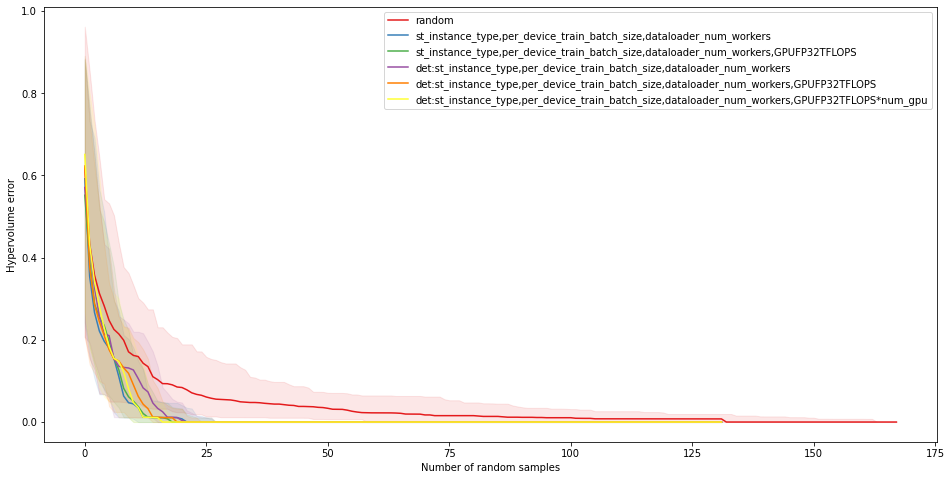

In [332]:
fig, ax = plt.subplots(figsize=(16, 8), facecolor='white')

for k, v in plotting_settings.items():
    ax.plot(true_hv-np.median(data[k], axis=0), color=v['color'], label=v['label'])

    quantiles = np.quantile(data[k], quantile_values_parameter, axis=0)
    ax.fill_between(x=np.arange(len(quantiles[0])), y1=true_hv-quantiles[0], y2=true_hv-quantiles[1], 
                    alpha=0.1, color=v['color'])

# ax.set_xlim(0, 100)
# ax.set_ylim(0, 10000)

ax.set_xlabel("Number of random samples")
ax.set_ylabel("Hypervolume error")

ax.legend()

## plot: vs cost

The results of some methods (some traces on the plots) are not asymptotically exact because some of the Pareto-front instances are not included in the subset of configurations considered by those methods. 

In [333]:
import plotly.graph_objects as go

# Create traces
fig = go.Figure()

for k, v in plotting_settings.items():
    interp_xs_length = 2000
    data_interpolated = np.zeros((len(data[k]), interp_xs_length))
    interp_xs = np.linspace(0, costs[k].max(), interp_xs_length)
    for n in range(data[k].shape[0]):
        data_interpolated[n, :] = np.interp(interp_xs, xp=costs[k][n, :], fp=data[k][n, :])
    
#     ax.plot(interp_xs, np.mean(data_interpolated, axis=0), color=v['color'], label=v['label'], linestyle=v['style'])
#     fig.add_trace(go.Scatter(x=interp_xs, y=true_hv-np.mean(data_interpolated, axis=0),
#                     mode='lines',
#                     name=v['label']))
    fig.add_trace(go.Scatter(x=interp_xs, y=true_hv-iqm(data_interpolated, quantiles=quantile_values_parameter),
                mode='lines',
                name=v['label']))

    quantiles = np.quantile(data_interpolated, quantile_values_parameter, axis=0)
#     ax.fill_between(x=interp_xs, y1=quantiles[0], y2=quantiles[1], 
#                     alpha=0.1, color=v['color'])


# fig.update_yaxes(type="log", range=(-1.9, 0))
fig.update_yaxes(type="log", range=(-50, 0))
# fig.update_yaxes(type="log")
# fig.update_yaxes(type="log")
# fig.update_yaxes(range=(0.00, 1))

# fig.update_xaxes(range=(0., 70))


fig.update_layout(
    autosize=True,
    width=1000,
    height=800,
#     margin=dict(
#         l=50,
#         r=50,
#         b=100,
#         t=100,
#         pad=4
#     ),
#     title="Plot Title",
    xaxis_title="Cost in $",
    yaxis_title="Hypervolume error",
#     legend_title="Legend Title",
    legend=dict(
        yanchor="top",
        y=-0.1,
        xanchor="left",
        x=0.01
    )
)

fig.show()

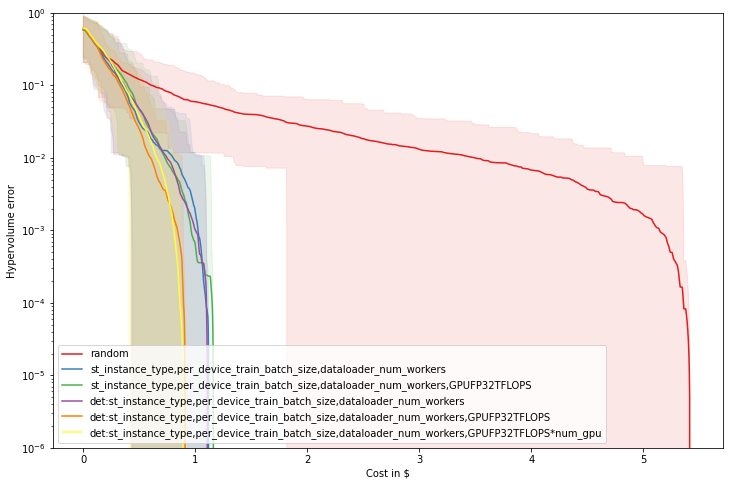

In [334]:
fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')

for k, v in plotting_settings.items():
    interp_xs_length = 2000
    data_interpolated = np.zeros((len(data[k]), interp_xs_length))
    interp_xs = np.linspace(0, costs[k].max(), interp_xs_length)
    for n in range(data[k].shape[0]):
        data_interpolated[n, :] = np.interp(interp_xs, xp=costs[k][n, :], fp=data[k][n, :])
    
#     ax.plot(interp_xs, true_hv-np.mean(data_interpolated, axis=0), color=v['color'], label=v['label'], linestyle=v['style'])
    ax.plot(interp_xs, true_hv-iqm(data_interpolated, quantile_values_parameter), color=v['color'], label=v['label'], linestyle=v['style'])

    quantiles = np.quantile(data_interpolated, quantile_values_parameter, axis=0)
    ax.fill_between(x=interp_xs, y1=true_hv-quantiles[0], y2=true_hv-quantiles[1], 
                    alpha=0.1, color=v['color'])

# ax.set_xlim(0, 40)

# ax.set_xscale('log', base=10) 
# ax.set_xlim(0.5, max(c.max() for c in costs.values()))
plt.yscale('log',base=10)
# ax.set_xlim(0., 40)
ax.set_ylim(1e-6, 1.)

ax.set_xlabel("Cost in $")
ax.set_ylabel("Hypervolume error")

ax.legend()

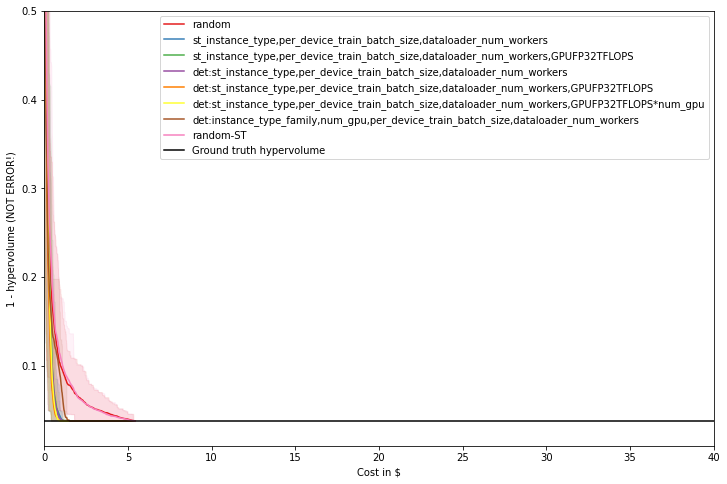

In [322]:
fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')

for k, v in plotting_settings.items():
    interp_xs_length = 2000
    data_interpolated = np.zeros((len(data[k]), interp_xs_length))
    interp_xs = np.linspace(0, costs[k].max(), interp_xs_length)
    for n in range(data[k].shape[0]):
        data_interpolated[n, :] = np.interp(interp_xs, xp=costs[k][n, :], fp=data[k][n, :])
    
    ax.plot(interp_xs, 1.-np.mean(data_interpolated, axis=0), color=v['color'], label=v['label'], linestyle=v['style'])

    quantiles = np.quantile(data_interpolated, quantile_values_parameter, axis=0)
    ax.fill_between(x=interp_xs, y1=1.-quantiles[0], y2=1.-quantiles[1], 
                    alpha=0.1, color=v['color'])

# ax.set_xlim(0, 40)

# plt.axvline(x=costs['determine_batch_size'].min(), color='b')
plt.axhline(y=1.-true_hv, color='k', label='Ground truth hypervolume')

# ax.set_xscale('log', base=10) 
# ax.set_xlim(0.5, max(c.max() for c in costs.values()))
# plt.yscale('log',base=10) 
ax.set_xlim(0., 40)
ax.set_ylim(1e-2, 0.5)

ax.set_xlabel("Cost in $")
ax.set_ylabel("1 - hypervolume (NOT ERROR!)")

ax.legend()